In [1]:
from IPython import display
import os
import glob
import imageio
import matplotlib.pyplot as plt
import numpy as np
import PIL
import tensorflow as tf
import tensorflow_probability as tfp
import time
from sklearn.model_selection import train_test_split
import random
from sklearn.metrics import confusion_matrix

In [2]:
np.random.seed(42)
tf.random.set_seed(42)

In [3]:
class CVAE(tf.keras.Model):
    def __init__(self, input_shape=(95, 128, 1), latent_dim=16):
        super(CVAE, self).__init__()
        self.input_shape = input_shape
        self.latent_dim = latent_dim
        
        self.encoder = tf.keras.Sequential([
            tf.keras.layers.Input(shape=input_shape),
            tf.keras.layers.Conv2D(32, 3, activation='relu', strides=2, padding='same'),  
            tf.keras.layers.Conv2D(64, 3, activation='relu', strides=2, padding='same'), 
            tf.keras.layers.Conv2D(128, 3, activation='relu', strides=2, padding='same'),
            tf.keras.layers.Flatten(), 
            tf.keras.layers.Dense(256, activation='relu'),
            tf.keras.layers.Dense(latent_dim + latent_dim)  
        ])
        
        self.decoder = tf.keras.Sequential([
            tf.keras.layers.Input(shape=(latent_dim,)),
            tf.keras.layers.Dense(12 * 16 * 128, activation='relu'),  
            tf.keras.layers.Reshape((12, 16, 128)),
            tf.keras.layers.Conv2DTranspose(64, 3, activation='relu', strides=2, padding='same'),  
            tf.keras.layers.Conv2DTranspose(32, 3, activation='relu', strides=2, padding='same'), 
            tf.keras.layers.Conv2DTranspose(1, 3, activation='linear', strides=2, padding='same') 
        ])

    def encode(self, x):
        mean_log_var = self.encoder(x)
        mean, log_var = tf.split(mean_log_var, num_or_size_splits=2, axis=1)
        return mean, log_var
    
    def reparameterize(self, mean, log_var):
        eps = tf.random.normal(shape=mean.shape)
        return eps * tf.exp(log_var * 0.5) + mean
    
    def decode(self, z):
        recon = self.decoder(z)
        return recon[:, :95, :, :] 
    
    def call(self, inputs):
        mean, log_var = self.encode(inputs)
        z = self.reparameterize(mean, log_var)
        return self.decode(z)

In [4]:
def compute_metrics(model, x):
    mean, log_var = model.encode(x)
    z = model.reparameterize(mean, log_var)
    x_recon = model.decode(z)
    
    recon_loss = tf.reduce_mean(
    tf.reduce_mean(tf.keras.losses.mse(x, x_recon), axis=[1, 2])
    )
    
    kl_loss = -0.5 * tf.reduce_mean(
        tf.reduce_sum(1 + log_var - tf.square(mean) - tf.exp(log_var), axis=1)
    )
    
    elbo = -(recon_loss + kl_loss)
    
    return recon_loss, kl_loss, elbo

In [5]:
 model = CVAE()

In [6]:
model.encoder.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 48, 64, 32)          │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 24, 32, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 12, 16, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 24576)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 256)                 │       6,291,712 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 32)                  │           8,224 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 6,392,608 (24.39 MB)

 Trainable params: 6,392,608 (24.39 MB)

 Non-trainable params: 0 (0.00 B)

In [7]:
model.decoder.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_2 (Dense)                      │ (None, 24576)               │         417,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ reshape (Reshape)                    │ (None, 12, 16, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose (Conv2DTranspose)   │ (None, 24, 32, 64)          │          73,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_1 (Conv2DTranspose) │ (None, 48, 64, 32)          │          18,464 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_2 (Conv2DTranspose) │ (None, 96, 128, 1)          │             289 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 510,337 (1.95 MB)

 Trainable params: 510,337 (1.95 MB)

 Non-trainable params: 0 (0.00 B)

In [8]:
def train_model(model, train_dataset, epochs):
    optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4)  # Updated learning rate
    train_recon_losses = []
    train_kl_losses = []
    train_elbos = []
    kl_weight = 0.0 
    kl_weight_step = 1.0 / (epochs // 2)
    
    for epoch in range(epochs):
        print(f'\nEpoch {epoch+1}/{epochs}')
        epoch_recon_loss = 0
        epoch_kl_loss = 0
        epoch_elbo = 0
        num_batches = 0
        
        for batch in train_dataset:
            with tf.GradientTape() as tape:
                recon_loss, kl_loss, elbo = compute_metrics(model, batch)
                total_loss = recon_loss + kl_weight * kl_loss
            grads = tape.gradient(total_loss, model.trainable_weights)
            optimizer.apply_gradients(zip(grads, model.trainable_weights))
            
            epoch_recon_loss += recon_loss
            epoch_kl_loss += kl_loss
            epoch_elbo += elbo
            num_batches += 1
        
        avg_recon_loss = epoch_recon_loss / num_batches
        avg_kl_loss = epoch_kl_loss / num_batches
        avg_elbo = epoch_elbo / num_batches
        
        train_recon_losses.append(avg_recon_loss)
        train_kl_losses.append(avg_elbo)
        train_elbos.append(avg_elbo)
        
        print(f'Recon Loss: {avg_recon_loss:.4f}, KL Loss: {avg_kl_loss:.4f}, ELBO: {avg_elbo:.4f}')

        # Update KL weight
        if epoch < (epochs // 2):
            kl_weight = min(1.0, kl_weight + kl_weight_step)
        else:
            kl_weight = 1.0
    
    return train_recon_losses, train_kl_losses, train_elbos

In [9]:
def test_model(model, test_dataset, threshold):
    class_a_metrics = {'recon': [], 'kl': [], 'elbo': []}
    class_b_metrics = {'recon': [], 'kl': [], 'elbo': []}
    true_labels = []
    recon_errors = []
    
    for batch_images, batch_labels in test_dataset:
        recon_loss, kl_loss, elbo = compute_metrics(model, batch_images)
        
        per_sample_recon = tf.reduce_mean(tf.keras.losses.mse(batch_images, model(batch_images)), axis=[1, 2])
        
        for i in range(len(batch_labels)):
            metrics = {
                'recon': per_sample_recon[i].numpy(),
                'kl': kl_loss.numpy(),  
                'elbo': elbo.numpy()    
            }
            label = 0 if batch_labels[i] == 'audible' else 1
            if label == 0:  
                for key in metrics:
                    class_a_metrics[key].append(metrics[key])
            else:  
                for key in metrics:
                    class_b_metrics[key].append(metrics[key])
                    
            true_labels.append(label)
            recon_errors.append(metrics['recon'])
    
    #threshold = np.mean(class_a_metrics['recon']) + 2 * np.std(class_a_metrics['recon'])
    pred_labels = [0 if error < threshold else 1 for error in recon_errors]
    
    return class_a_metrics, class_b_metrics, true_labels, pred_labels

In [10]:
def plot_results(train_metrics, test_a_metrics, test_b_metrics, true_labels, pred_labels, threshold, metric_to_plot='recon'):
    plt.figure(figsize=(15, 10))
    
    plt.subplot(2, 2, 1)
    plt.plot(train_metrics[metric_to_plot])
    plt.title(f'Training {metric_to_plot.capitalize()} vs Epochs')
    plt.xlabel('Epoch')
    plt.ylabel(metric_to_plot.capitalize())
    
    plt.subplot(2, 2, 2)
    plt.hist(test_a_metrics[metric_to_plot], bins=50, alpha=0.5, label='Audible')
    plt.hist(test_b_metrics[metric_to_plot], bins=50, alpha=0.5, label='Inaudible')
    plt.axvline(threshold, color='r', linestyle='--', label=f'Threshold={threshold:.2f}')
    plt.title(f'{metric_to_plot.capitalize()} Distribution')
    plt.xlabel(metric_to_plot.capitalize())
    plt.ylabel('Frequency')
    plt.legend()
    
    cm = confusion_matrix(true_labels, pred_labels)
    plt.subplot(2, 2, 3)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=['Audible', 'Inaudible'], 
                yticklabels=['Audible', 'Inaudible'])
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    
    plt.tight_layout()
    plt.show()

In [11]:
def get_image_paths_and_labels(audible_folder, inaudible_folder):
    audible_images = []
    inaudible_images = []

    for root, _, files in os.walk(audible_folder):
        for f in files:
            if f.endswith(".png"):
                audible_images.append(os.path.join(root, f))

    for root, _, files in os.walk(inaudible_folder):
        for f in files:
            if f.endswith(".png"):
                inaudible_images.append(os.path.join(root, f))

    audible_labels = ['audible'] * len(audible_images)
    inaudible_labels = ['inaudible'] * len(inaudible_images)

    image_paths = audible_images + inaudible_images
    labels = audible_labels + inaudible_labels

    combined = list(zip(image_paths, labels))
    random.shuffle(combined)
    image_paths, labels = zip(*combined)

    return list(image_paths), list(labels)

In [12]:
def prepare_dataset(image_paths, target_size, batch_size):
    def preprocess_image(image_path):
        img = tf.io.read_file(image_path)
        img = tf.image.decode_png(img, channels=1)
        img = tf.image.resize(img, target_size)
        img = tf.image.per_image_standardization(img)
        return img

    dataset = tf.data.Dataset.from_tensor_slices(image_paths)
    dataset = dataset.map(lambda x: preprocess_image(x), num_parallel_calls=tf.data.AUTOTUNE)
    dataset = dataset.shuffle(buffer_size=len(image_paths))
    dataset = dataset.batch(batch_size).prefetch(tf.data.AUTOTUNE)
    return dataset

In [13]:
def preprocess_image_with_labels(image_path, label, target_size):
    img = tf.io.read_file(image_path)
    img = tf.image.decode_png(img, channels=1)
    img = tf.image.resize(img, target_size)
    img = tf.image.per_image_standardization(img)
    return img, label

def prepare_dataset_with_labels(image_paths, labels, target_size, batch_size):
    ds = tf.data.Dataset.from_tensor_slices((image_paths, labels))
    ds = ds.map(lambda x, y: preprocess_image_with_labels(x, y, target_size),
                num_parallel_calls=tf.data.AUTOTUNE)
    ds = ds.shuffle(buffer_size=len(image_paths))
    ds = ds.batch(batch_size)
    ds = ds.prefetch(tf.data.AUTOTUNE)
    return ds

In [14]:
from sklearn.model_selection import train_test_split

image_dir = "/kaggle/input/trainingdata"
train_image_paths = [os.path.join(root, file)
                    for root, _, files in os.walk(image_dir)
                    for file in files if file.endswith('.png')]
print(f"Number of training samples: {len(train_image_paths)}")

audible_folder = "/kaggle/input/testdataset/Audible_spectrograms"
inaudible_folder = "/kaggle/input/testdataset/Inaudible_spectrogram"
test_image_paths, test_labels = get_image_paths_and_labels(audible_folder, inaudible_folder)
print(f"Test samples: {len(test_image_paths)}")

target_size = (95, 128)
batch_size = 32

random.shuffle(train_image_paths)
train_paths, val_paths = train_test_split(train_image_paths, test_size=0.2, random_state=42)
train_dataset = prepare_dataset(train_paths, target_size, batch_size)
val_dataset = prepare_dataset(val_paths, target_size, batch_size)
test_dataset = prepare_dataset_with_labels(test_image_paths, test_labels, target_size, batch_size)

Number of training samples: 14208
Test samples: 230


In [30]:
epochs = 20
train_recon_losses, train_kl_losses, train_elbos = train_model(model, train_dataset, epochs=epochs)


Epoch 1/20
Recon Loss: 0.3409, KL Loss: 488.5749, ELBO: -488.9160

Epoch 2/20
Recon Loss: 0.6999, KL Loss: 6.4352, ELBO: -7.1351

Epoch 3/20
Recon Loss: 0.7133, KL Loss: 0.0374, ELBO: -0.7507

Epoch 4/20
Recon Loss: 0.7188, KL Loss: 0.0091, ELBO: -0.7279

Epoch 5/20
Recon Loss: 0.7192, KL Loss: 0.0023, ELBO: -0.7216

Epoch 6/20
Recon Loss: 0.7191, KL Loss: 0.0009, ELBO: -0.7200

Epoch 7/20
Recon Loss: 0.7190, KL Loss: 0.0005, ELBO: -0.7195

Epoch 8/20
Recon Loss: 0.7190, KL Loss: 0.0003, ELBO: -0.7193

Epoch 9/20
Recon Loss: 0.7192, KL Loss: 0.0002, ELBO: -0.7194

Epoch 10/20
Recon Loss: 0.7190, KL Loss: 0.0001, ELBO: -0.7191

Epoch 11/20
Recon Loss: 0.7192, KL Loss: 0.0001, ELBO: -0.7193

Epoch 12/20
Recon Loss: 0.7189, KL Loss: 0.0001, ELBO: -0.7190

Epoch 13/20
Recon Loss: 0.7189, KL Loss: 0.0001, ELBO: -0.7190

Epoch 14/20
Recon Loss: 0.7189, KL Loss: 0.0001, ELBO: -0.7190

Epoch 15/20
Recon Loss: 0.7191, KL Loss: 0.0001, ELBO: -0.7191

Epoch 16/20
Recon Loss: 0.7189, KL Loss: 0.0

In [31]:
def compute_train_recon_errors(model, dataset):
    recon_errors = []
    for batch in dataset:
        recon_loss, _, _ = compute_metrics(model, batch)
        per_sample_recon = tf.reduce_mean(tf.keras.losses.mse(batch, model(batch)), axis=[1, 2])
        recon_errors.extend(per_sample_recon.numpy())
    return recon_errors

In [32]:
val_recon_errors = compute_train_recon_errors(model, val_dataset)
threshold = np.mean(val_recon_errors) + 2 * np.std(val_recon_errors)
print(f"Threshold calculated from validation set: {threshold:.4f}")

Threshold calculated from validation set: 1.0070


In [33]:
print(threshold)
test_a_metrics, test_b_metrics, true_labels, pred_labels = test_model(model, test_dataset, threshold)

1.006987601518631


In [35]:
train_metrics = {
    'recon': train_recon_losses,
    'kl': train_kl_losses,
    'elbo': train_elbos
}

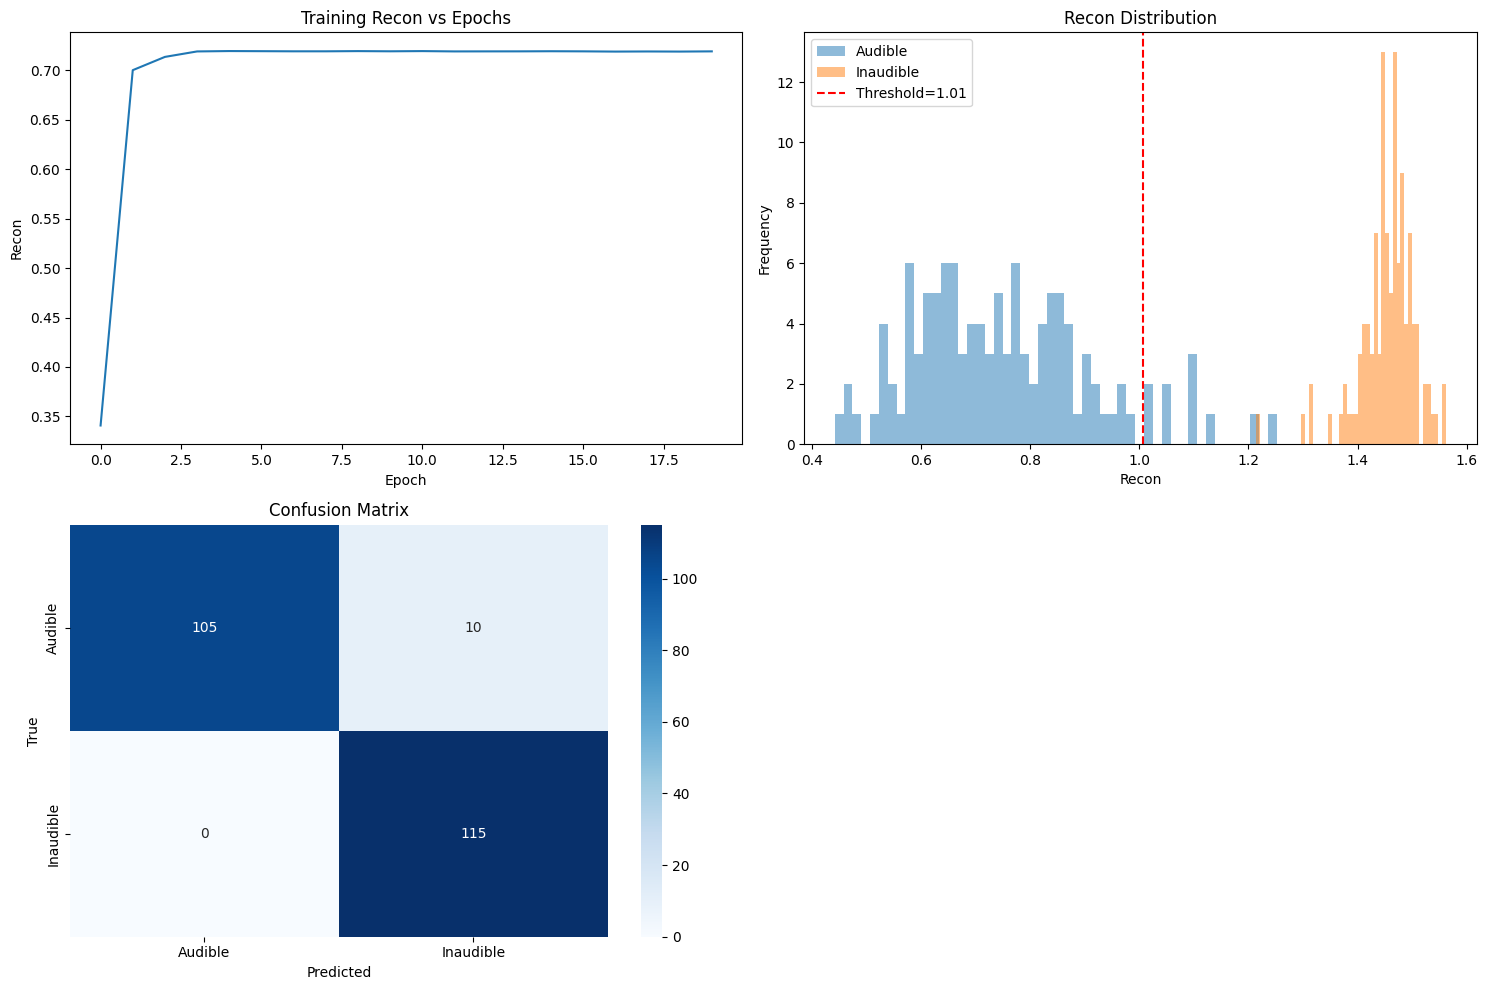


Recon Statistics:
Audible class- Mean: 0.7517, Std: 0.1645
Inaudible class - Mean: 1.4544, Std: 0.0509


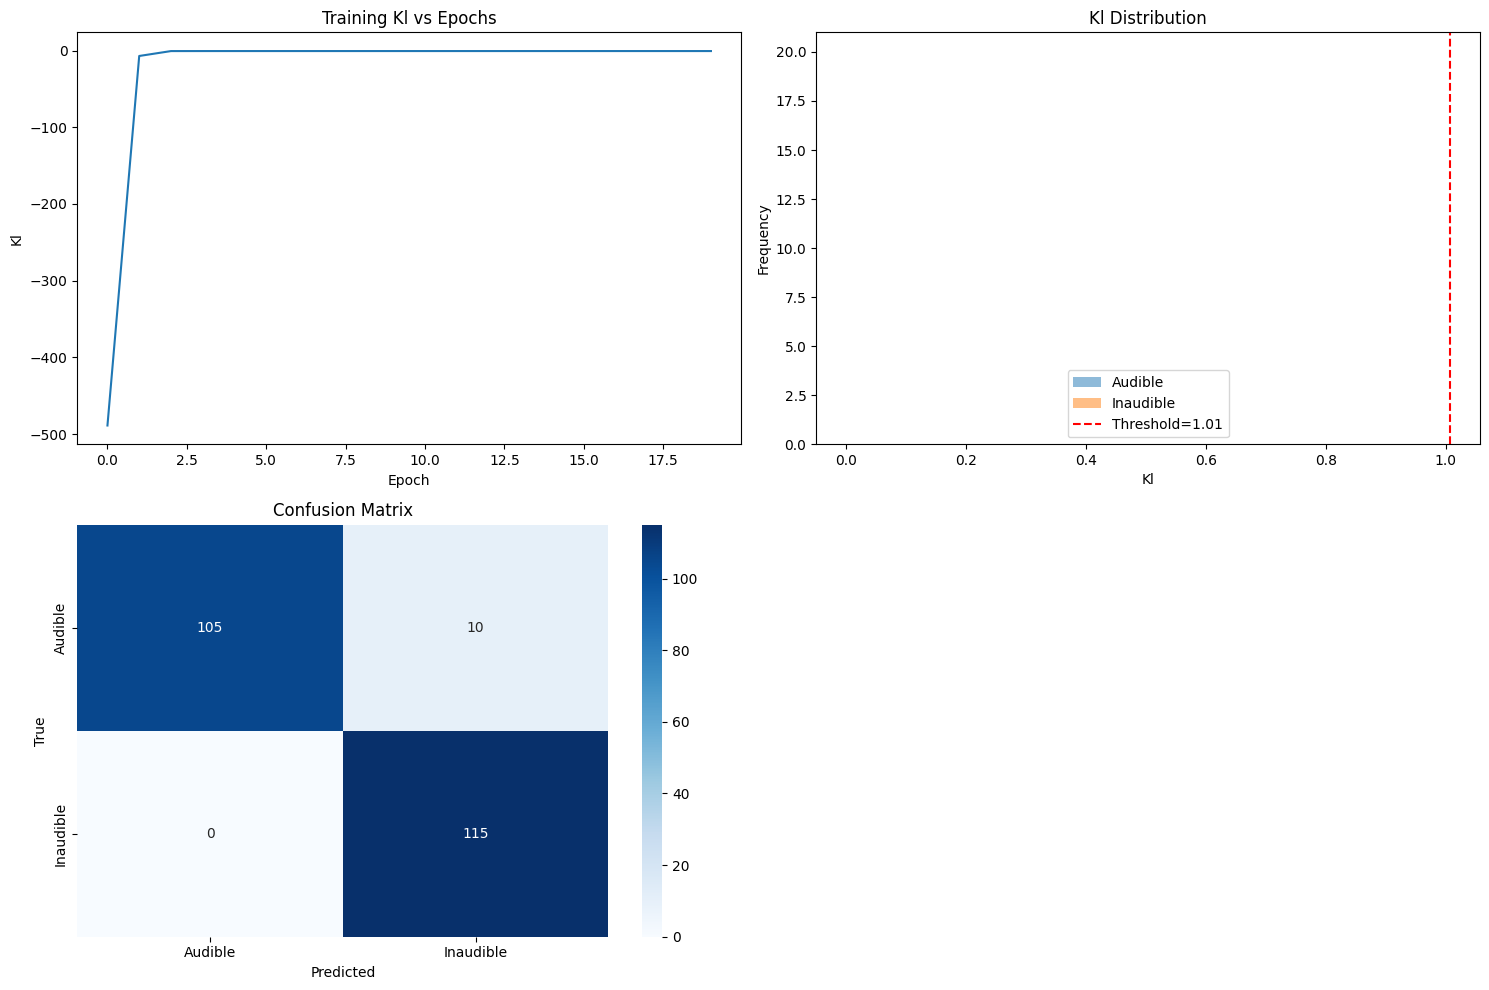


Kl Statistics:
Audible class- Mean: 0.0017, Std: 0.0005
Inaudible class - Mean: 0.0017, Std: 0.0004


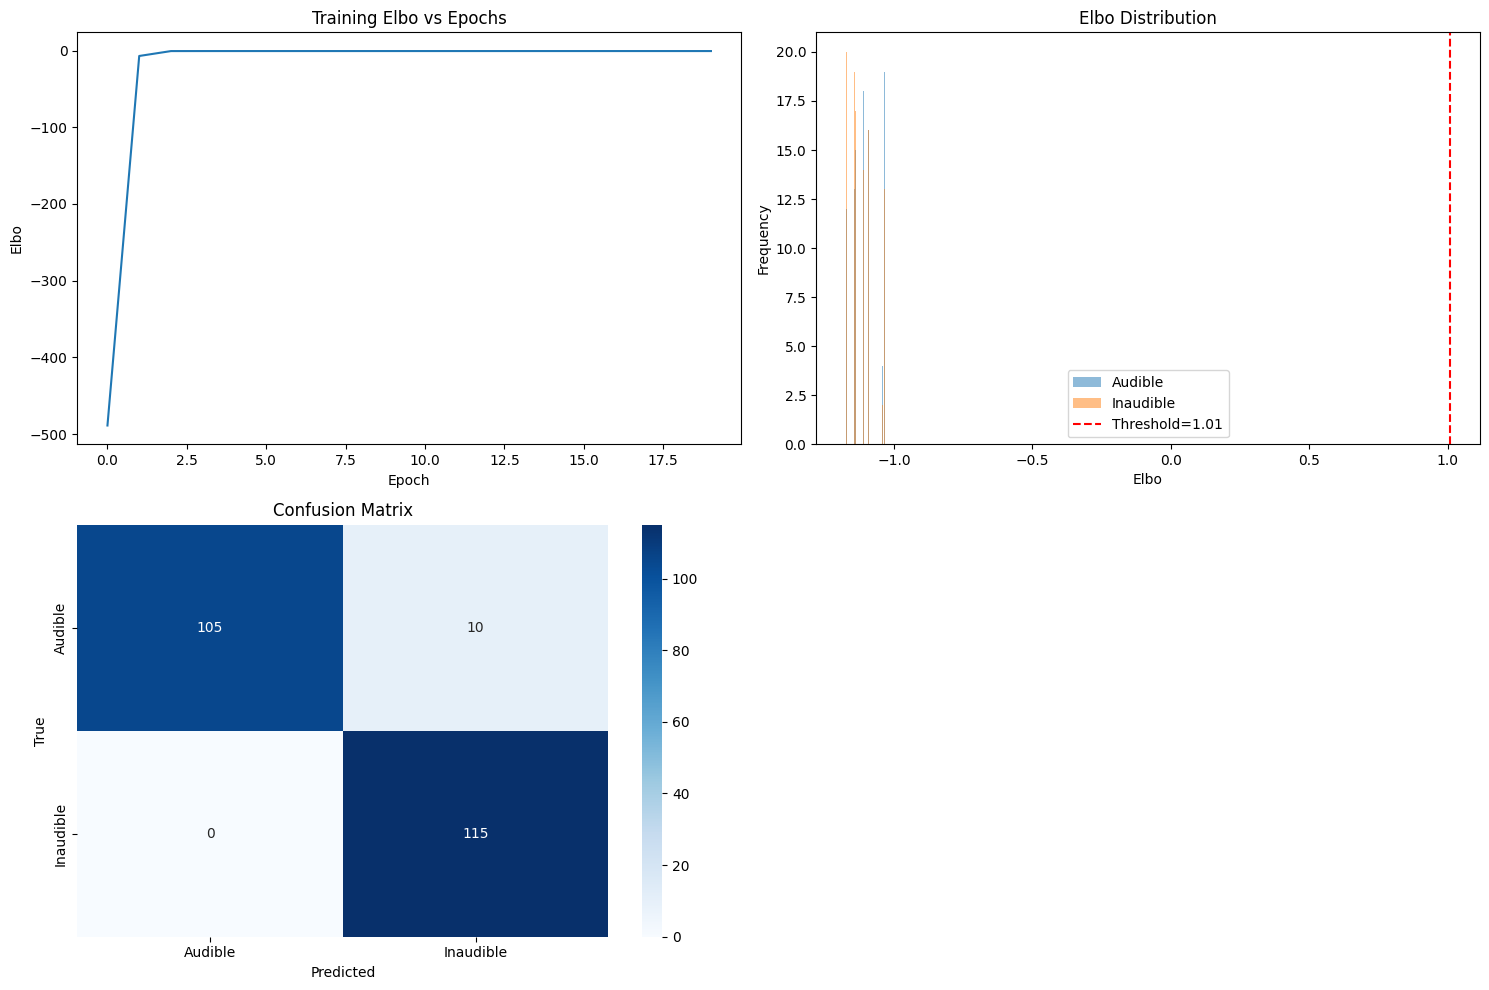


Elbo Statistics:
Audible class- Mean: -1.0975, Std: 0.0466
Inaudible class - Mean: -1.1113, Std: 0.0465

Confusion Matrix Statistics (Threshold=1.0070):
True Negatives: 105
False Positives: 10
False Negatives: 0
True Positives: 115
Accuracy: 0.9565
Precision: 0.9200
Recall: 1.0000


In [36]:
import seaborn as sns
for metric in ['recon', 'kl', 'elbo']:
    plot_results(train_metrics, test_a_metrics, test_b_metrics, true_labels, pred_labels, threshold, metric_to_plot=metric)
    
    print(f"\n{metric.capitalize()} Statistics:")
    print(f"Audible class- Mean: {np.mean(test_a_metrics[metric]):.4f}, Std: {np.std(test_a_metrics[metric]):.4f}")
    print(f"Inaudible class - Mean: {np.mean(test_b_metrics[metric]):.4f}, Std: {np.std(test_b_metrics[metric]):.4f}")

tn, fp, fn, tp = confusion_matrix(true_labels, pred_labels).ravel()
total = tn + fp + fn + tp

accuracy = (tp + tn) / total if total > 0 else 0
precision = tp / (tp + fp) if (tp + fp) > 0 else 0
recall = tp / (tp + fn) if (tp + fn) > 0 else 0

print(f"\nConfusion Matrix Statistics (Threshold={threshold:.4f}):")
print(f"True Negatives: {tn}")
print(f"False Positives: {fp}")
print(f"False Negatives: {fn}")
print(f"True Positives: {tp}")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")

In [21]:
print(threshold)

0.9827551543712616


Explained variance by PCA components: [0.7024791  0.10911027]


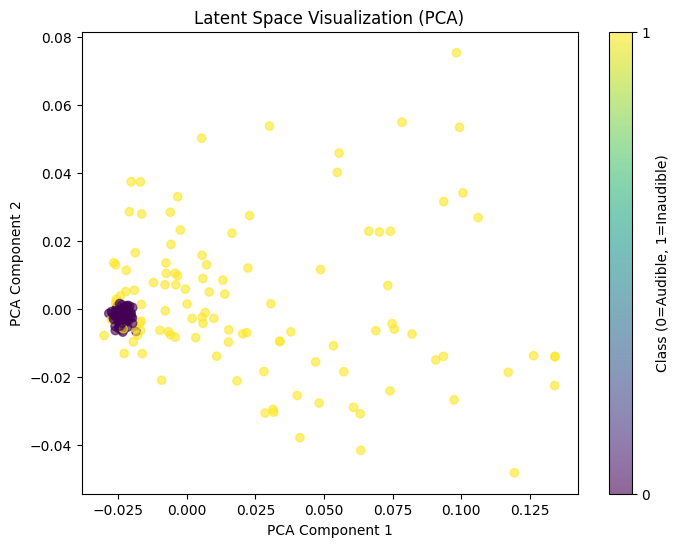

In [37]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

def visualize_latent_space(model, test_dataset, method='pca'):
    latent_means = []
    labels = []
    
    for batch_images, batch_labels in test_dataset:
        mean, _ = model.encode(batch_images)
        latent_means.append(mean.numpy())
        labels.extend([0 if label == 'audible' else 1 for label in batch_labels])
    
    latent_means = np.concatenate(latent_means, axis=0)
    
    if method == 'pca':
        reducer = PCA(n_components=2)
        reduced = reducer.fit_transform(latent_means)
        explained_variance = reducer.explained_variance_ratio_
        print(f"Explained variance by PCA components: {explained_variance}")
    elif method == 'tsne':
        reducer = TSNE(n_components=2, random_state=42)
        reduced = reducer.fit_transform(latent_means)
    
    plt.figure(figsize=(8, 6))
    scatter = plt.scatter(reduced[:, 0], reduced[:, 1], c=labels, cmap='viridis', alpha=0.6)
    plt.colorbar(scatter, ticks=[0, 1], label='Class (0=Audible, 1=Inaudible)')
    plt.title(f'Latent Space Visualization ({method.upper()})')
    plt.xlabel(f'{method.upper()} Component 1')
    plt.ylabel(f'{method.upper()} Component 2')
    plt.show()

visualize_latent_space(model, test_dataset, method='pca')  # or 'tsne'


Latent Dimension Correlations with Class Label:
Dim 0: Correlation = 0.5328, p-value = 0.0000
Dim 1: Correlation = 0.4193, p-value = 0.0000
Dim 2: Correlation = -0.3981, p-value = 0.0000
Dim 3: Correlation = 0.4816, p-value = 0.0000
Dim 4: Correlation = -0.4938, p-value = 0.0000
Dim 5: Correlation = -0.6418, p-value = 0.0000
Dim 6: Correlation = -0.3448, p-value = 0.0000
Dim 7: Correlation = 0.6023, p-value = 0.0000
Dim 8: Correlation = -0.1730, p-value = 0.0085
Dim 9: Correlation = -0.5474, p-value = 0.0000
Dim 10: Correlation = 0.2679, p-value = 0.0000
Dim 11: Correlation = -0.2603, p-value = 0.0001
Dim 12: Correlation = 0.6668, p-value = 0.0000
Dim 13: Correlation = 0.3117, p-value = 0.0000
Dim 14: Correlation = 0.0059, p-value = 0.9286
Dim 15: Correlation = 0.0953, p-value = 0.1496


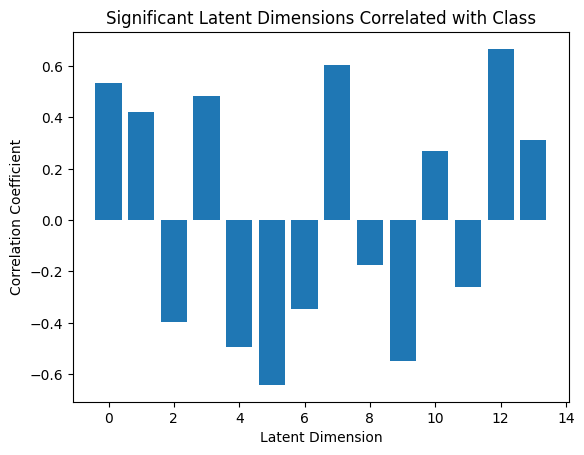

In [38]:
from scipy.stats import pearsonr

def latent_correlation_analysis(model, test_dataset):
    latent_means = []
    labels = []
    
    for batch_images, batch_labels in test_dataset:
        mean, _ = model.encode(batch_images)
        latent_means.append(mean.numpy())
        labels.extend([0 if label == 'audible' else 1 for label in batch_labels])
    
    latent_means = np.concatenate(latent_means, axis=0)
    labels = np.array(labels)
    
    correlations = []
    for i in range(model.latent_dim):
        corr, p_value = pearsonr(latent_means[:, i], labels)
        correlations.append((i, corr, p_value))
    
    print("\nLatent Dimension Correlations with Class Label:")
    for dim, corr, p in correlations:
        print(f"Dim {dim}: Correlation = {corr:.4f}, p-value = {p:.4f}")
    
    significant = [(dim, corr) for dim, corr, p in correlations if p < 0.05]
    if significant:
        dims, corrs = zip(*significant)
        plt.bar(dims, corrs)
        plt.title('Significant Latent Dimensions Correlated with Class')
        plt.xlabel('Latent Dimension')
        plt.ylabel('Correlation Coefficient')
        plt.show()

latent_correlation_analysis(model, test_dataset)

In [39]:
import numpy as np
threshold_save_path = "/kaggle/working/threshold_9565.npy"
np.save(threshold_save_path, threshold)
print(f"Threshold saved to {threshold_save_path}")

Threshold saved to /kaggle/working/threshold_9565.npy


In [40]:
h5_model_path = "/kaggle/working/convvae_model_9565.h5"
model.save(h5_model_path, save_format='h5')
print(f"Model saved in .h5 format to {h5_model_path}")

Model saved in .h5 format to /kaggle/working/convvae_model_9565.h5


In [41]:
import zipfile 
zip_path = "/kaggle/working/convvae_model.zip"
with zipfile.ZipFile(zip_path, 'w', zipfile.ZIP_DEFLATED) as zipf:
    zipf.write(h5_model_path, "convvae_model.h5") 
print(f"Model zipped as {zip_path}")

Model zipped as /kaggle/working/convvae_model_h5.zip
